<a href="https://colab.research.google.com/github/Endalebob/Deep-Learning-Lab/blob/main/forward_backward_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np

## Creating Layers

**I've thoroughly examined and understood the derivation of the following code by performing manual calculations on paper. The step-by-step process below outlines my understanding of how this backpropagation code is formulated. I relied on the explanations provided in the book [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap2.html) to enhance my comprehension**


**Explanation:**

1. **Forward Pass:**
   - During the forward pass (`forward` method), the layer computes its output (`self.output`) by applying a transformation to the input values (`inputs`). The output is calculated as the dot product of inputs and weights, plus biases.

2. **Error Calculation for Output Layer:**
   - The error is calculated at the output layer by comparing the predicted output (`self.output`) with the target values. This error is represented by `dvalues`, which denotes the gradient of the loss with respect to the output.

3. **Explanation of `dvalues`:**
   - `dvalues` represents the layer error, which is the gradient of the loss with respect to the output values of the layer. It quantifies how much the loss would change with respect to the layer's output. This layer error is calculated for the output layer and used as a starting point for backpropagation.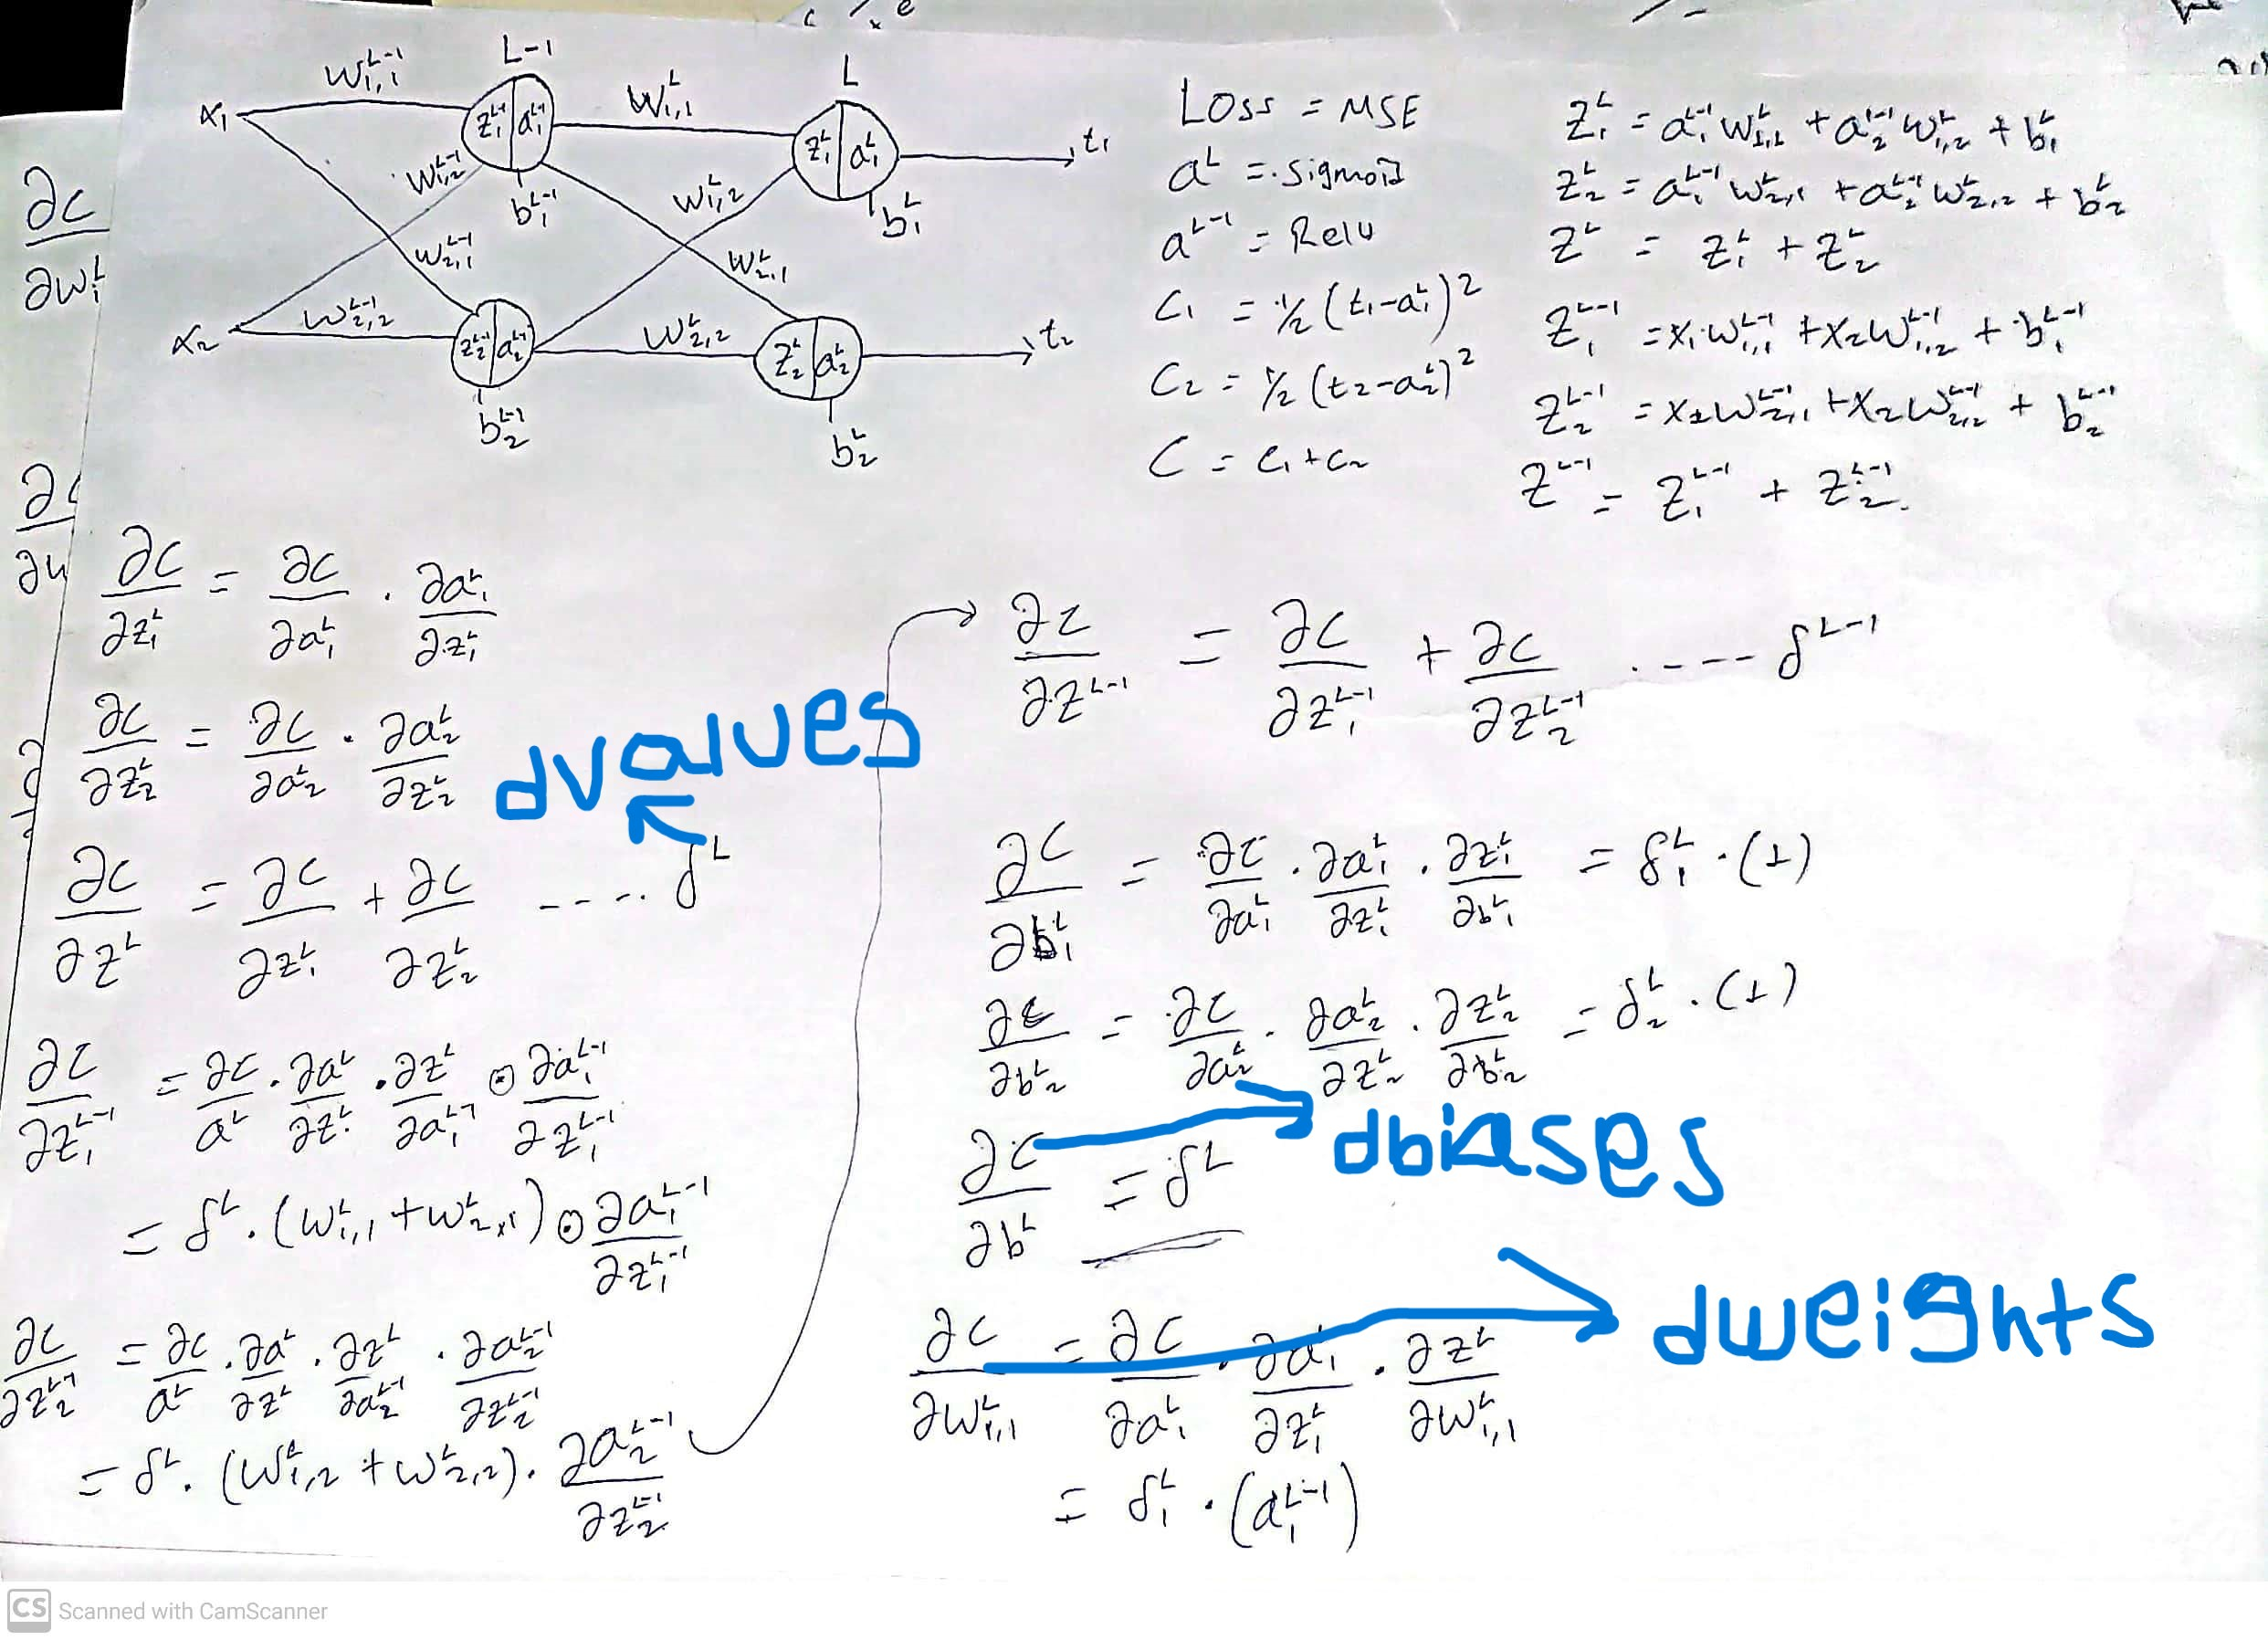
   


4. **Backward Pass:**
   - **Gradients on Parameters (`dweights` and `dbiases`):**
     - `self.dweights`: The gradient of the loss with respect to the weights is calculated by taking the dot product of the transpose of the input values (`self.inputs.T`) and `dvalues`.
     - `self.dbiases`: The gradient of the loss with respect to the biases is computed by summing up the `dvalues` along each column (axis=0) and keeping the dimensions consistent with the biases.

   - **Gradient on Inputs (`self.dinputs`):**
     - `self.dinputs`: The gradient of the loss with respect to the inputs is calculated by taking the dot product of `dvalues` and the transpose of the weights (`self.weights.T`).

5. **Propagating Error Backward:**
   - The calculated `dvalues` is then used to propagate the error backward through the network. This involves computing gradients for each layer, updating weights and biases, and iteratively minimizing the overall loss.

In [ ]:
class DenseLayer:
  # Layer initialization
  def __init__(self, n_inputs, n_neurons):
    # Initialize weights and biases
    self.weights = 0.01 * torch.rand(n_inputs, n_neurons)
    self.biases = torch.zeros((1, n_neurons))

  # Forward pass
  def forward(self, inputs):
    # record the inputs
    self.inputs = inputs
    # Calculate output values from inputs, weights and biases
    self.output = torch.matmul(inputs, self.weights) + self.biases

  # Backward pass
  def backward(self, dvalues):
    # Gradients on parameters
    self.dweights = torch.dot(self.inputs.T, dvalues)
    self.dbiases = torch.sum(dvalues, axis=0, keepdims=True)
    # Gradient on values
    self.dinputs = torch.dot(dvalues, self.weights.T)

## Activation Functions

In [ ]:
class Activation_ReLU:
  # Forward pass
  def forward(self, inputs):
    # Remember input values
    self.inputs = inputs
    self.output = torch.max(torch.tensor(0),inputs)
  # Backward pass
  def backward(self, dvalues):
    self.dinputs = dvalues
    # Zero gradient where input values were negative
    self.dinputs[self.inputs <= 0] = 0

In [ ]:
class Activation_Softmax:
  # Forward pass
  def forward(self, inputs):
    # Get unnormalized probabilities
    exp_values = torhc.exp(inputs - torch.max(inputs, axis=1, keepdim=True).values)
    # Normalize them for each sample
    probabilities = exp_values / torch.sum(exp_values, axis=1, keepdim=True)
    self.output = probabilities
  # Backward pass
  def backward(self, dvalues):
    # Create uninitialized array
    self.dinputs = torch.empty_like(dvalues)
    # Enumerate outputs and gradients
    for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
      # Flatten output array
      single_output = single_output.reshape(-1, 1)
      # Calculate Jacobian matrix of the output and
      jacobian_matrix = torch.diagflat(single_output) - torch.dot(single_output, single_output.T)
    # Calculate sample-wise gradient
    # and add it to the array of sample gradients
    self.dinputs[index] = torch.dot(jacobian_matrix, single_dvalues)

In [ ]:
class Activation_Sigmoid:
  # Forward pass
  def forward(self, inputs):
    self.output = 1 / (1 + torch.exp(-inputs))

  # Backward pass
  def backward(self, dvalues):
    # Derivative of sigmoid
    sigmoid_derivative = self.output * (1 - self.output)
    # Calculate sample-wise gradient
    self.dinputs = dvalues * sigmoid_derivative

## Loss

In [ ]:
class Loss_CategoricalCrossentropy() :
  # Forward pass
  def forward(self, y_pred, y_true):
    samples = len(y_pred)
    # Clip data to prevent division by 0
    # Clip both sides to not drag mean towards any value
    y_pred_clipped = torch.clip(y_pred, 1e-8, 1 - 1e-8)
    # only if categorical labels
    if len(y_true.shape) == 1:
      correct_confidences = y_pred_clipped[range(samples), y_true]
    # Mask values - only for one-hot encoded labels
    elif len(y_true.shape) == 2:
      correct_confidences = torch.sum(y_pred_clipped * y_true, axis=1)
    log_loss = -torch.log(correct_confidences)
    data_loss = torch.mean(log_loss)
    return data_loss
  # Backward pass
  def backward(self, dvalues, y_true):
    # Number of samples
    samples = len(dvalues)
    # Number of labels in every sample
    # We'll use the first sample to count them
    labels = len(dvalues[0])
    # If labels are sparse, turn them into one-hot vector
    if len(y_true.shape) == 1:
      y_true = torch.eye(labels)[y_true]
    # Calculate gradient
    self.dinputs = -y_true / dvalues
    # Normalize gradient
    self.dinputs = self.dinputs / samples

In [ ]:
class Loss_MeanSquaredError():
    # Forward pass
    def forward(self, y_pred, y_true):
        # Calculate the mean squared error loss
        data_loss = torch.mean((y_pred - y_true) ** 2)
        return data_loss

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Gradient of the Mean Squared Error loss
        self.dinputs = 2 * (dvalues - y_true) / samples
        return self.dinputs

## Accuracy

In [ ]:
class Accuracy():
  def calculate(self, y_pred, y_true):
    predictions = torch.argmax(y_pred, axis=1)
    if len(y_true.shape) == 2:
      y_true = torch.argmax(y_true, axis=1)
    accuracy = torch.mean((predictions == y_true).float())
    return accuracy

## Optimizers

In [ ]:
class Optimizer_SGD:
  # Initialize optimizer - set settings,
  def __init__(self, learning_rate=0.01):
    self.learning_rate = learning_rate
  # Update parameters
  def update_params(self, layer):
    layer.weights += -self.learning_rate * layer.dweights
    layer.biases += -self.learning_rate * layer.dbiases